## 0. Set up

In [159]:
import warnings
warnings.filterwarnings('ignore')

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime

## 1. Funções

In [558]:
def groupby_location(dataframe, country, date_column, location_column, 
    list_of_cases_columns, location = None
    ):
    
    list_of_columns = [date_column, location_column]
    for column in list_of_cases_columns:
        list_of_columns.append(column)
    dict_of_columns = {}
    for column in list_of_cases_columns:
        dict_of_columns[column] = "sum"
    
    if location is None:     
        dataframe = dataframe[list_of_columns]
        dataframe = (dataframe
                         .groupby([date_column])
                         .agg(dict_of_columns)
                         .reset_index())
        dataframe["location"] = country
        dataframe = dataframe.sort_values(by=date_column)
    else:
        dataframe = dataframe[dataframe[location_column] == location]
        dataframe = dataframe[list_of_columns]
        dataframe = (dataframe
                         .groupby([date_column])
                         .agg(dict_of_columns)
                         .reset_index())
        dataframe["location"] = location
        dataframe = dataframe.sort_values(by=date_column)
        
    return dataframe

def correcting_types(dataframe, date_column, date_format, list_of_cases_columns):
    dataframe[date_column] = (dataframe[date_column]
                             .apply(lambda x: datetime.strptime(x, date_format)))
    
    for column in list_of_cases_columns:
        dataframe[column] = dataframe[column].astype(float)
        
    return dataframe    

def create_date_table(start, end):
    dataframe = pd.DataFrame({"date": pd.date_range(start, end)})
    
    return dataframe

def get_date_index(dataframe, date_column, cases_column, max_date):
    calendar = create_date_table(min(dataframe[dataframe[cases_column]>=1][date_column]), max_date)
    calendar = calendar.reset_index()
    calendar.rename(columns={'index':'date_index'}, inplace=True)
    calendar['date_index'] = calendar['date_index'] + 1
    
    return calendar

def date_linear_coef(dataframe, date_column, cases_column, max_date, index):
    calendar = get_date_index(dataframe, date_column, cases_column, max_date)
    dataframe = dataframe[dataframe[cases_column]>=1]
    dataframe = dataframe.merge(calendar, how = "left", on=date_column)
    a, b = np.polyfit(dataframe[index], np.log(dataframe[cases_column]), 1)
    
    return a, b

def date_linear_predict(dataframe, date_column, cases_column, location_column, max_date, index):
    a,b = date_linear_coef(dataframe, date_column, cases_column, max_date, index)
    predictions = get_date_index(dataframe, date_column, cases_column, max_date)
    predictions['date_predict'] = predictions[index].apply(lambda x: float(a)*float(x) + float(b))
    predictions['location'] = dataframe[location_column].max()
    
    return predictions

## 2. Bases de dados

In [559]:
covid19_br_kaggle = pd.read_csv("../data/coronavirus_brazil_kaggle/brazil_covid19.csv")
covid19_br_vicosa_cites = pd.read_csv("../data/coronavirus_brazil_vicosa/cases-brazil-cities.csv")
covid19_br_vicosa_cites_times = pd.read_csv("../data/coronavirus_brazil_vicosa/cases-brazil-cities-time.csv")
covid19_br_vicosa_states = pd.read_csv("../data/coronavirus_brazil_vicosa/cases-brazil-states.csv")
covid19_br_vicosa_brazil = pd.read_csv("../data/coronavirus_brazil_vicosa/cases-brazil-total.csv")
gov_br_novocoronavirus = pd.read_csv("../data/coronavirus_brazil_vicosa/plataforma-saude-gov-br-novocoronavirus.csv")
covid19_br_nagano = pd.read_csv("../data/coronavirus_nagano/base_diaria.csv")

#### 1.1 Exploração de dados premliminar

##### kaggle_brazil

In [560]:
covid19_br_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      981 non-null    object
 1   hour      684 non-null    object
 2   state     981 non-null    object
 3   suspects  981 non-null    int64 
 4   refuses   981 non-null    int64 
 5   cases     981 non-null    int64 
 6   deaths    981 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 53.8+ KB


In [561]:
covid19_br_kaggle.head()

,date,hour,state,suspects,refuses,cases,deaths
0,2020-01-30,16:00,Minas Gerais,1,0,0,0
1,2020-01-30,16:00,Rio de Janeiro,1,0,0,0
2,2020-01-30,16:00,Santa Catarina,0,2,0,0
3,2020-01-30,16:00,São Paulo,3,1,0,0
4,2020-01-30,16:00,Rio Grande do Sul,2,2,0,0


In [562]:
columns_list = ["suspects", "refuses", "cases", "deaths"]
covid19_br_kagle_brasil = groupby_location(covid19_br_kaggle, "Brasil", "date", "state", columns_list)
covid19_br_kagle_sp = groupby_location(covid19_br_kaggle, "Brasil", "date", "state", columns_list, location = "São Paulo")

covid19_br_kagle_brasil = correcting_types(covid19_br_kagle_brasil, "date", '%Y-%m-%d', columns_list)
covid19_br_kagle_sp = correcting_types(covid19_br_kagle_sp, "date", '%Y-%m-%d', columns_list)

In [563]:
print("Faixa de data:\nData mínima: {0}\nData máxima: {1}".format(min(covid19_br_kaggle['date']), max(covid19_br_kaggle['date'])))
print("\nNúmero de casos confirmados até data máxima:\nBrasil: {0}\nSão Paulo: {1}".format(covid19_br_kaggle_brasil['cases'].tail(1).sum(), covid19_br_kaggle_sp['cases'].tail(1).sum()))

Faixa de data:
Data mínima: 2020-01-30
Data máxima: 2020-03-29

Número de casos confirmados até data máxima:
Brasil: 4266
São Paulo: 1451


In [564]:
covid19_brasil = pd.concat([covid19_br_kagle_brasil, covid19_br_kagle_sp], ignore_index=True)

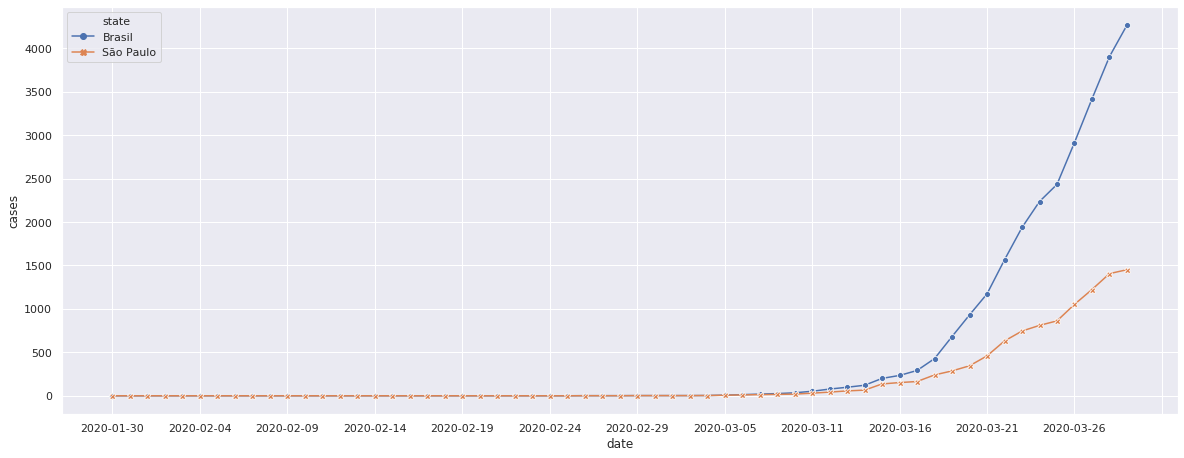

In [565]:
plt.figure(figsize=(20,7.5))
ax = sns.lineplot(x="date", y="cases",
                  hue="state", markers=True, style = "state",
                  dashes=False, data=covid19_brasil_sp)

ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

##### universidade_de_vicosa

In [566]:
covid19_br_vicosa_cites_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2041 entries, 0 to 2040
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        2041 non-null   object
 1   country     2041 non-null   object
 2   state       2041 non-null   object
 3   city        2041 non-null   object
 4   ibgeID      2041 non-null   int64 
 5   newCases    2041 non-null   int64 
 6   totalCases  2041 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 111.7+ KB


In [567]:
covid19_br_vicosa_cites_times.head(5)

,date,country,state,city,ibgeID,newCases,totalCases
0,2020-02-25,Brazil,SP,São Paulo/SP,3550308,1,1
1,2020-02-25,Brazil,TOTAL,TOTAL,3550308,1,1
2,2020-02-29,Brazil,SP,São Paulo/SP,3550308,1,2
3,2020-02-29,Brazil,TOTAL,TOTAL,3550308,1,2
4,2020-03-04,Brazil,SP,São Paulo/SP,3550308,1,3


In [568]:
columns_list = ["newCases", "totalCases"]
covid19_br_vicosa_sp = groupby_location(covid19_br_vicosa_cites_times, "Brasil", "date", "city", columns_list, location = "São Paulo/SP")
covid19_br_vicosa_sp = correcting_types(covid19_br_vicosa_sp, "date", '%Y-%m-%d', columns_list)

In [569]:
print("Faixa de data:\nData mínima: {0}\nData máxima: {1}".format(min(covid19_br_vicosa_cites_times['date']), max(covid19_br_vicosa_cites_times['date'])))
print("\nNúmero de casos confirmados até data máxima:\nSão Paulo: {0}".format(covid19_br_vicosa_sp['totalCases'].tail(1).sum()))

Faixa de data:
Data mínima: 2020-02-25
Data máxima: 2020-03-29

Número de casos confirmados até data máxima:
São Paulo: 1183.0


In [570]:
## join
covid19_br_vicosa_sp['cases'] = covid19_br_vicosa_sp['totalCases']
covid19_br_vicosa_sp = covid19_br_vicosa_sp[['date','location','cases']]
covid19_brasil = covid19_brasil[['date','location','cases']]
covid19_brasil = pd.concat([covid19_brasil, covid19_br_vicosa_sp], ignore_index=True)

#### bases nagano

In [571]:
covid19_br_nagano.head()

,data,municipio,uf,casos confirmados,mortes,fonte
0,26/02/2020,São Paulo,SP,1,NaN,NaN
1,27/02/2020,São Paulo,SP,1,NaN,NaN
2,28/02/2020,São Paulo,SP,1,NaN,NaN
3,29/02/2020,São Paulo,SP,2,NaN,NaN
4,01/03/2020,São Paulo,SP,2,NaN,NaN


In [572]:
columns_list = ["casos confirmados"]
covid19_br_nagano_sp = groupby_location(covid19_br_nagano, "Brasil", "data", "municipio", columns_list, location = "São Paulo")
covid19_br_nagano_sp = correcting_types(covid19_br_nagano_sp, "data", '%d/%m/%Y', columns_list)
covid19_br_nagano_sp['location'] = "São Paulo/SP - Nagano"
covid19_br_nagano_sp.rename(columns={'data':'date', 'casos confirmados':'cases'}, inplace=True)

In [573]:
print("Faixa de data:\nData mínima: {0}\nData máxima: {1}".format(min(covid19_br_nagano_sp['date']), max(covid19_br_nagano_sp['date'])))
print("\nNúmero de casos confirmados até data máxima:\nBrasil: {0}\nSão Paulo: {1}".format(covid19_br_nagano_sp['cases'].tail(1).sum(), covid19_br_nagano_sp['cases'].tail(1).sum()))

Faixa de data:
Data mínima: 2020-02-26 00:00:00
Data máxima: 2020-03-29 00:00:00

Número de casos confirmados até data máxima:
Brasil: 1272.0
São Paulo: 1272.0


In [574]:
covid19_brasil = pd.concat([covid19_brasil, covid19_br_nagano_sp], ignore_index=True)

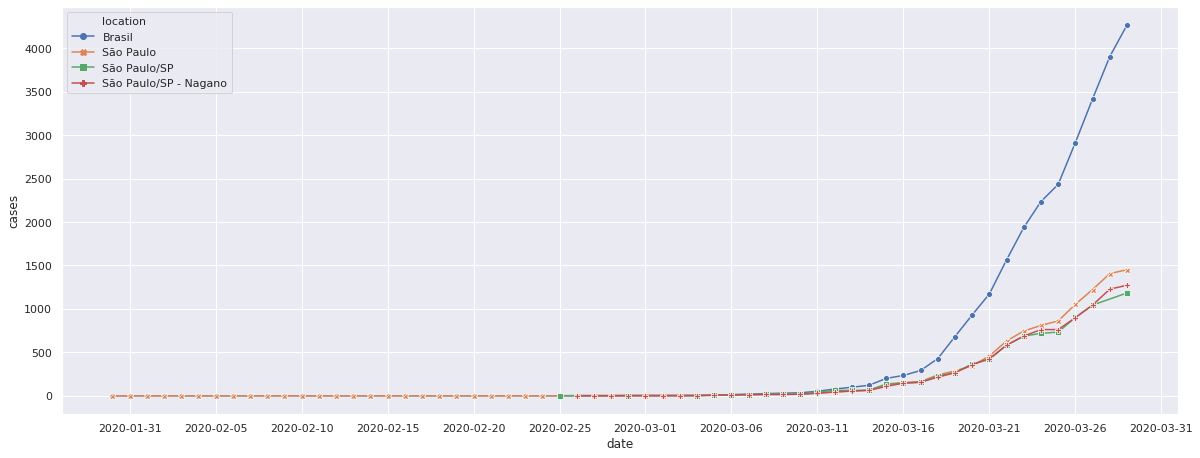

In [575]:
plt.figure(figsize=(20,7.5))
ax = sns.lineplot(x="date", y="cases",
                  hue="location", markers=True, style = "location",
                  dashes=False, data=covid19_brasil)

ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

## Ajuste log-linear

In [587]:
covid19_brasil["log_cases"] = np.log(covid19_brasil["cases"])

In [588]:
sp_city_df = covid19_brasil[covid19_brasil['location'] == 'São Paulo/SP']
sp_city_nangano = covid19_brasil[covid19_brasil['location'] == 'São Paulo/SP - Nagano']
sp_state_df = covid19_brasil[covid19_brasil['location'] == 'São Paulo']
brasil_df = covid19_brasil[covid19_brasil['location'] == 'Brasil']

(737480.0, 737516.0)

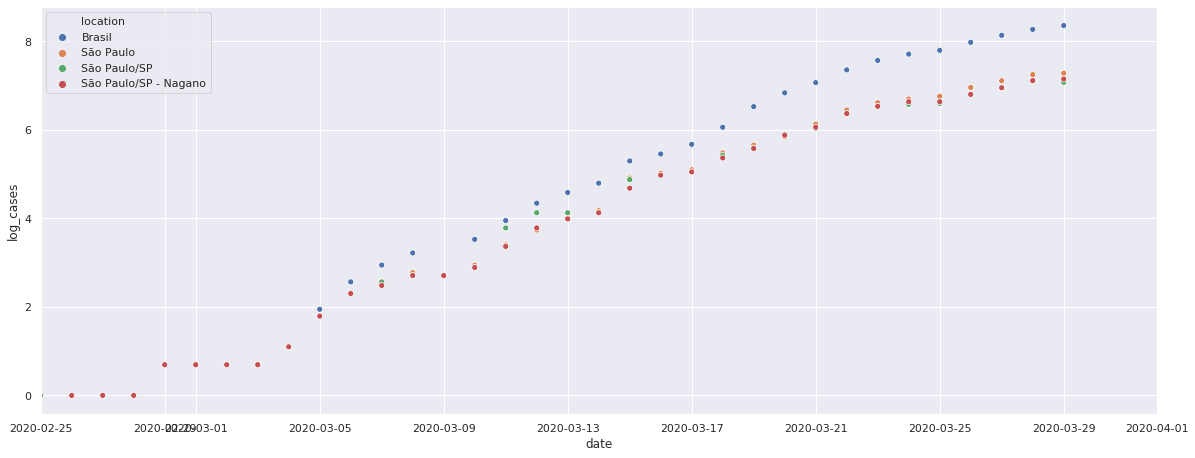

In [589]:
plt.figure(figsize=(20,7.5))
ax = sns.scatterplot(x="date", y="log_cases",
                     hue="location", markers=True, data=covid19_brasil)


# control x and y limits
ax.set_xlim(min(covid19_brasil[covid19_brasil["cases"]>=1]['date']),datetime.strptime("2020-04-01", '%Y-%m-%d'))

In [590]:
sp_city_predictions = date_linear_predict(sp_city_df, "date", "cases", "location", "2020-04-05", "date_index")
sp_state_df_predictions = date_linear_predict(sp_state_df, "date", "cases", "location", "2020-04-05", "date_index")
brasil_df_predictions = date_linear_predict(brasil_df, "date", "cases", "location", "2020-04-05", "date_index")

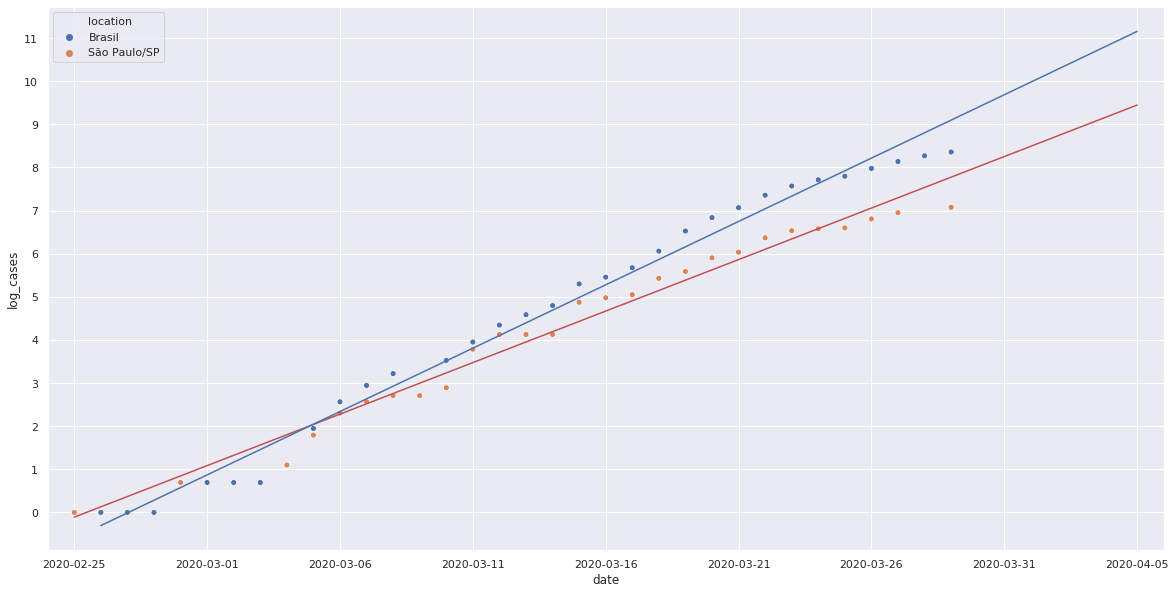

In [594]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="date", y="log_cases",
                     hue="location", markers=True, data=covid19_brasil[covid19_brasil['location'].isin(["Brasil","São Paulo/SP"])])

# control x and y limits
ax.set_xlim(datetime.strptime("2020-02-24", '%Y-%m-%d'),datetime.strptime("2020-04-06", '%Y-%m-%d'))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

plt.plot(sp_city_predictions['date'], sp_city_predictions['date_predict'], color='r')
plt.plot(brasil_df_predictions['date'], brasil_df_predictions['date_predict'], color='b')
plt.show()

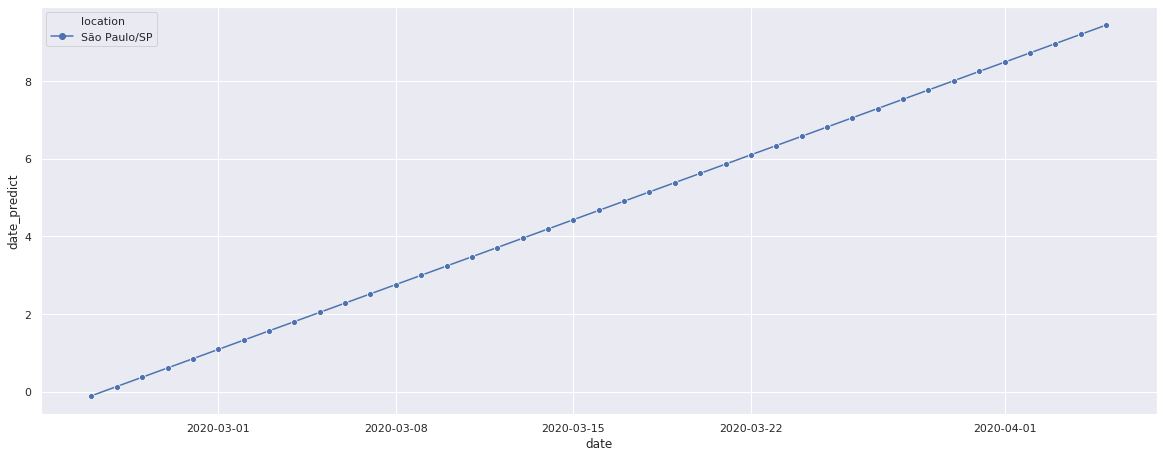

In [467]:
plt.figure(figsize=(20,7.5))
ax = sns.lineplot(x="date", y="date_predict",
                  hue="location", markers=True, style = "location",
                  dashes=False, data=sp_city_predictions)

plt.plot()

# ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

## análise de sexta feira

In [ ]:
calendar = create_date_table(start, end)

In [323]:
def date_interpolation_cum_sum(df, date_column, location):
    max_date = max(df['date'].astype("string"))
    min_date = min(df['date'].astype("string"))
    calendar = create_date_table(min_date,max_date)
    calendar = calendar.merge(df, how = "left", left_on = 'calendar_date', right_on = date_column)
    
    calendar = calendar.drop(columns = ['date'])
    calendar.rename(columns={'calendar_date':'date'}, inplace=True)
    calendar['state'] = location
    
#     calendar = calendar['cases'].cumsum()
    
    return calendar

In [324]:
date_interpolation_cum_sum(test, 'date', "São Paulo - capital")

,date,state,cases,log,reg
0,2020-02-25,São Paulo - capital,1.0,0.000000,0.908424
1,2020-02-26,São Paulo - capital,NaN,NaN,NaN
2,2020-02-27,São Paulo - capital,NaN,NaN,NaN
3,2020-02-28,São Paulo - capital,NaN,NaN,NaN
4,2020-02-29,São Paulo - capital,2.0,0.693147,1.178225
5,2020-03-01,São Paulo - capital,NaN,NaN,NaN
6,2020-03-02,São Paulo - capital,NaN,NaN,NaN
7,2020-03-03,São Paulo - capital,NaN,NaN,NaN
8,2020-03-04,São Paulo - capital,3.0,1.098612,1.448026
9,2020-03-05,São Paulo - capital,6.0,1.791759,1.717827


In [293]:
max_date = max(test['date'].astype("string"))

In [280]:
def linear_log_adjust(dataframe, cases_column):
    dataframe = dataframe[dataframe[cases_column] >= 1]
    dataframe = dataframe.reset_index()    
    a, b = np.polyfit(dataframe["index"], np.log(dataframe[cases_column]), 1)
    dataframe['reg'] = dataframe["index"].apply(lambda x: a*x + b)
    dataframe = dataframe.drop(columns = ['index'])
    
    return dataframe

In [299]:
test = linear_log_adjust(sp_city_df, "cases")

In [300]:
test.head()

,date,state,cases,log,reg
0,2020-02-25,São Paulo - capital,1,0.000000,0.908424
1,2020-02-29,São Paulo - capital,2,0.693147,1.178225
2,2020-03-04,São Paulo - capital,3,1.098612,1.448026
3,2020-03-05,São Paulo - capital,6,1.791759,1.717827
4,2020-03-06,São Paulo - capital,10,2.302585,1.987628


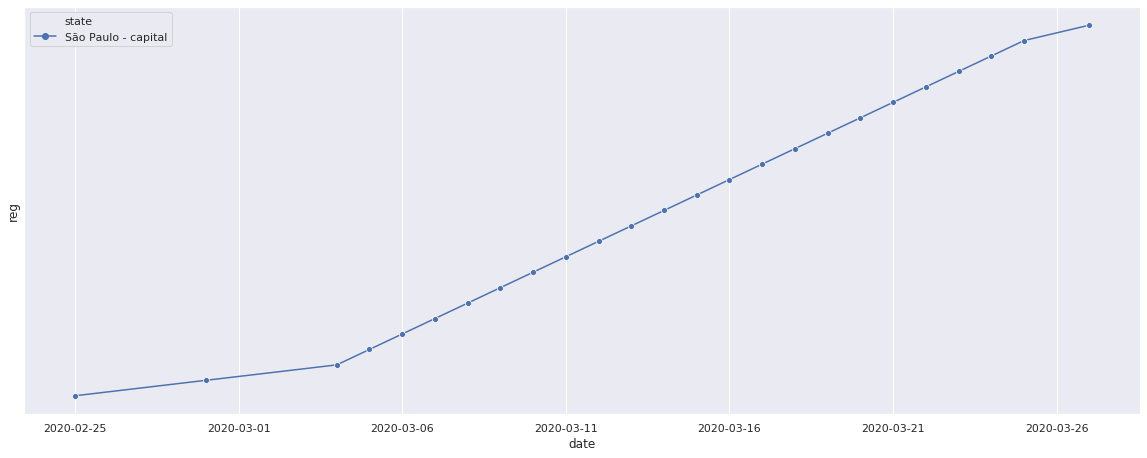

In [283]:
plt.figure(figsize=(20,7.5))
ax = sns.lineplot(x="date", y="reg",
                  hue="state", markers=True, style = "state",
                  dashes=False, data=test)

ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

In [282]:
test.head()

,date,state,cases,log,reg
0,2020-02-25,São Paulo - capital,1,0.000000,0.908424
1,2020-02-29,São Paulo - capital,2,0.693147,1.178225
2,2020-03-04,São Paulo - capital,3,1.098612,1.448026
3,2020-03-05,São Paulo - capital,6,1.791759,1.717827
4,2020-03-06,São Paulo - capital,10,2.302585,1.987628


In [277]:
a, b = np.polyfit(test["index"], test['log'], 1)

In [274]:
test.head()

,index,date,state,cases,log
0,0,2020-02-25,São Paulo - capital,1,0.000000
1,1,2020-02-29,São Paulo - capital,2,0.693147
2,2,2020-03-04,São Paulo - capital,3,1.098612
3,3,2020-03-05,São Paulo - capital,6,1.791759
4,4,2020-03-06,São Paulo - capital,10,2.302585


In [266]:
sp_city_df.head()

,date,state,cases
0,2020-02-25,São Paulo - capital,1
1,2020-02-29,São Paulo - capital,2
2,2020-03-04,São Paulo - capital,3
3,2020-03-05,São Paulo - capital,6
4,2020-03-06,São Paulo - capital,10


In [270]:
np.polyfit(sp_city_df['date'], np.log(sp_city_df['cases']), 1)

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('float64')

In [269]:
sp_city_df.head()

,date,state,cases,log
0,2020-02-25,São Paulo - capital,1,0.000000
1,2020-02-29,São Paulo - capital,2,0.693147
2,2020-03-04,São Paulo - capital,3,1.098612
3,2020-03-05,São Paulo - capital,6,1.791759
4,2020-03-06,São Paulo - capital,10,2.302585
